<a href="https://colab.research.google.com/github/Gibsdevops/ML_tensorflowLite/blob/main/Copy_of_tflite_c03_exercise_convert_model_to_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

print(tf.__version__)

2.18.0


# Download Fashion MNIST Dataset


In [ ]:
# Define the splits using strings for weighted proportions
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True,
                         split=('train[:80%]', 'train[80%:90%]', 'train[90%:]'))

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
# Note: num_examples here will represent the total number of examples in the original 'train' split.
# If you need the number of examples in the newly created splits, you'll need to iterate or get the dataset sizes.
num_classes = info.features['label'].num_classes

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [ ]:
# Write a function to normalize and resize the images

def format_example(image, label):
  # Cast image to float32
  image = tf.cast(image, tf.float32)
  # Resize the image if necessary
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  # Normalize the image in the range [0, 1]
  image = image / 255.0
  return image, label

In [ ]:
# Set the batch size to 32

BATCH_SIZE = 32

## Create a Dataset from images and labels

In [ ]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.shuffle(num_examples // 4).map(format_example).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_example).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_example).batch(BATCH_SIZE)

# Building the model

In [ ]:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0
_________________________________________________________________
dense (Dense)                (None, 64)                247872
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
"""

In [ ]:
# Build the model shown in the previous cell


model = tf.keras.Sequential([
  # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(),
  # Set the number of filters to 32, kernel size to 3 and use ReLU activation
  tf.keras.layers.Conv2D(32, 3, padding='same', activation=tf.nn.relu),
  # Flatten the output layer to 1 dimension
  tf.keras.layers.Flatten(),
  # Add a fully connected layer with 64 hidden units and ReLU activation
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  # Attach a final softmax classification head
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
  ])

# Set the loss and accuracy metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,922 (1.55 MB)

 Trainable params: 406,922 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [ ]:
model.fit(train_batches,
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - accuracy: 0.7861 - loss: 0.6021 - val_accuracy: 0.8748 - val_loss: 0.3475
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.8886 - loss: 0.3073 - val_accuracy: 0.8973 - val_loss: 0.2685
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.9090 - loss: 0.2552 - val_accuracy: 0.9062 - val_loss: 0.2559
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9238 - loss: 0.2097 - val_accuracy: 0.9098 - val_loss: 0.2379
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9333 - loss: 0.1802 - val_accuracy: 0.9177 - val_loss: 0.2307
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.9429 - loss: 0.1541 - val_accuracy: 0.9212 - val_loss: 0.2234
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.9523 - loss: 0.1296 - val_accuracy: 0.9230 - val_loss: 0.2327
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9602 -

# Exporting to TFLite

In [ ]:
#export_dir = 'saved_model/1'

# Use the tf.saved_model API to export the SavedModel

# Your Code Here
#tf.saved_model.save(model, export_dir)

In [ ]:
optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#dataset representation
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield[input_value]

converter.representative_dataset = representative_data_gen

#set target
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpam3xg44w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137119174080656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174078928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174080080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174075280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174081424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174081808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174081232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137119174078544: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test if your model is working

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

# Iterate through the test batches
for img_batch, label_batch in test_batches.take(50):
  # Iterate through each image and label in the batch
  for i in range(img_batch.shape[0]):
    img = img_batch[i:i+1] # Get a single image with a batch size of 1
    label = label_batch[i]

    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label)
    test_images.append(np.array(img))

In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

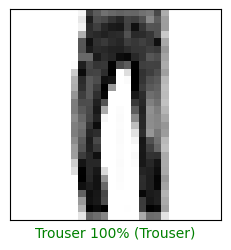

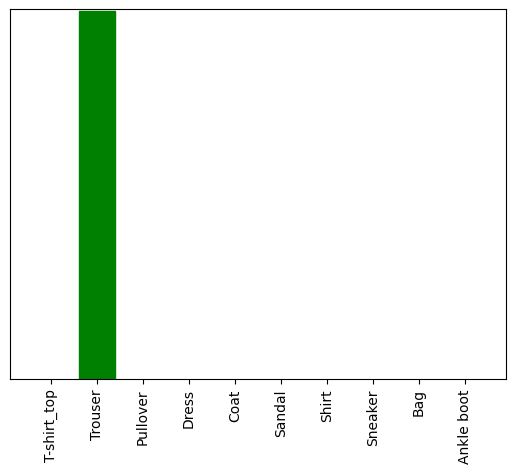

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 49 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [ ]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploying TFLite model

Now once you've the trained TFLite model downloaded, you can ahead and deploy this on an Android/iOS application by placing the model assets in the appropriate location.

# Prepare the test images for download (Optional)

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq fmnist_test_images.zip -r test_images/

In [ ]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass